# Saravana Kumar_AI/ML
# Payroll Anomaly Detection Engine - Project

## 1. Problem Statement

Payroll systems handle sensitive financial data such as employee salaries and overtime payments. 
In large organizations, manual monitoring of payroll records is difficult and error-prone, which 
can lead to undetected salary manipulation or fake overtime claims.

In most real-world payroll scenarios, confirmed fraud labels are not available. This makes 
supervised learning approaches unsuitable. Instead, the goal is to automatically identify 
unusual or abnormal payroll patterns that significantly deviate from normal employee behavior.

This project aims to design and implement a prototype Anomaly Detection Engine using 
unsupervised machine learning techniques to detect potential salary manipulation and fake 
overtime cases. The solution focuses on learning normal payroll behavior from historical data 
and flagging anomalous records for further human investigation.


## 2. Approach Overview

The proposed solution follows an anomaly detection–based approach to identify unusual payroll 
patterns related to salary manipulation and fake overtime claims. Since labeled fraud data is 
generally unavailable, an unsupervised learning strategy is adopted.

The overall approach consists of the following steps:

1. **Data Preparation**  
   Payroll-related features such as base salary and overtime hours are collected and prepared 
   for modeling.

2. **Unsupervised Anomaly Detection**  
   An Isolation Forest model is used to learn normal payroll behavior and assign anomaly scores 
   to each payroll record.

3. **Anomaly Flagging**  
   Records that significantly deviate from normal behavior are flagged as anomalies for further 
   review.

4. **Evaluation Without Labels**  
   As ground-truth labels are unavailable, evaluation is performed using anomaly rate monitoring 
   and manual inspection of flagged cases.

5. **Design for Real-time and Batch Processing**  
   The notebook implements a batch prototype while outlining how the same model can be extended 
   to real-time payroll monitoring in production.

This notebook demonstrates a working prototype along with the design rationale, evaluation 
strategy, and deployment considerations for a real-world anomaly detection engine.


## 3. Algorithm Selection Rationale

Isolation Forest is selected as the core anomaly detection algorithm for this project due to the 
following reasons:

- **Unsupervised Learning Capability**  
  Isolation Forest does not require labeled data, making it suitable for payroll fraud detection 
  scenarios where confirmed fraud labels are rarely available.

- **Effective for Rare Anomalies**  
  Payroll anomalies such as salary manipulation or fake overtime are typically rare. Isolation 
  Forest is specifically designed to isolate such rare and unusual observations efficiently.

- **Scalability and Efficiency**  
  The algorithm works well with high-dimensional data and scales efficiently to large payroll 
  datasets, which is important for enterprise payroll systems.

- **Interpretability at a High Level**  
  Although it is an ensemble-based method, Isolation Forest provides anomaly scores that can be 
  used to rank suspicious payroll records for human review.

  
  In practice, Isolation Forest is implemented using the following syntax:
  ```python
  IsolationForest(n_estimators=100, contamination=0.02, random_state=42)

The contamination parameter represents the expected proportion of anomalies in the data.
In payroll systems, anomalies are rare, so a small contamination value is appropriate.

Interpretability at a High Level
The model produces anomaly scores that allow payroll records to be ranked based on their level
of abnormality, enabling efficient human review.

### Why Not DBSCAN?

DBSCAN is not chosen for this payroll anomaly detection task due to the following limitations:

- Sensitivity to Parameter Selection
DBSCAN requires careful tuning of eps and min_samples, which is challenging in high-dimensional
payroll data where density varies across departments and employee roles.

- Scalability Issues
DBSCAN is computationally expensive for large datasets and does not scale as efficiently as
Isolation Forest for enterprise-scale payroll systems.

- Difficulty Handling Varying Densities
Payroll data often contains clusters with different densities (e.g., different salary bands
across roles). DBSCAN struggles in such scenarios and may incorrectly classify normal points
as noise.

Due to these reasons, Isolation Forest provides a more robust, scalable, and practical solution
for payroll anomaly detection in this project.


### Anomaly Score Calculation in Isolation Forest

Isolation Forest computes an anomaly score for each data point using the following formula:

\[
s(x, m) = 2^{-\frac{E(h(x))}{c(m)}}
\]

Where:
- \(E(h(x))\) is the average path length required to isolate data point \(x\)
- \(c(m)\) is the average path length of unsuccessful searches in a binary tree with \(m\) samples

Intuitively, anomalous payroll records are isolated using fewer splits, resulting in shorter path 
lengths and higher anomaly scores. Normal payroll records require more splits and therefore receive 
lower anomaly scores.


## 4. Pseudocode: Payroll Anomaly Detection Engine

BEGIN

INPUT:
    Payroll dataset (BasePay, OvertimePay, TotalPay)

BATCH PIPELINE:
    Load historical payroll data
    Clean data (remove nulls, ensure numeric values)
    Select numerical payroll features
    Scale features using standard normalization
    Train Isolation Forest model on scaled data
    Save trained model and preprocessing objects

REAL-TIME PIPELINE:
    Receive payroll event via API
    Validate input schema and values
    Apply same preprocessing and scaling
    Generate anomaly score using trained model
    IF anomaly score exceeds threshold THEN
        Flag payroll record as anomalous
        Log or alert for further investigation
    ELSE
        Mark payroll record as normal
    END IF

MONITORING:
    Track anomaly rate over time
    Monitor feature distribution changes
    IF drift detected THEN
        Retrain model using recent payroll data
    END IF

OUTPUT:
    Anomaly score and anomaly flag for each payroll record

END


## 5. Data Loading and Preparation

### Dataset Description

This project uses the publicly available **San Francisco Employee Salary** dataset, which contains 
detailed payroll information such as base pay, overtime pay, and total compensation for employees.

The dataset serves as a realistic representation of payroll data typically processed in enterprise 
HR and finance systems, making it suitable for anomaly detection use cases such as salary manipulation 
and fake overtime claims.

---

### Synthetic Anomaly Injection

Since real-world payroll fraud labels are rarely available, **synthetic anomalies were injected** 
into the dataset to simulate abnormal payroll behavior. Approximately **2% of the records** were 
modified to represent realistic fraud-like scenarios:

- **Salary manipulation**: Unusually high base pay compared to similar employees
- **Fake or excessive overtime**: Abnormally high overtime pay relative to base pay

A reference column named `Injected_Anomaly` was added:
- `0` → Normal payroll record
- `1` → Injected anomalous payroll record

---

### Purpose of the Injection Label

The `Injected_Anomaly` column is included **only for validation and demonstration purposes**.  
It allows comparison between detected anomalies and known injected cases to assess whether the 
model is identifying abnormal behavior patterns.

**Important Note**:  
Isolation Forest is an **unsupervised learning algorithm** and **does not use labels during training**.  
The model is trained **only on numerical payroll features**, and the injection label is explicitly 
excluded from the feature set. As a result, anomaly detection remains fully unsupervised.

---

### Feature Selection

For anomaly detection, the following numerical payroll features are used:

- `BasePay`
- `OvertimePay`
- `TotalPay`

These features capture both direct compensation and irregular pay patterns, making them effective 
signals for detecting payroll-related anomalies.


In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/sf_salary_with_anomalies.csv")

df.head()


C:\Users\yashw\AppData\Local\Temp\ipykernel_13224\2739007793.py:4: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/sf_salary_with_anomalies.csv")


,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status,Injected_Anomaly
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.00,400184.25,NaN,567595.43,567595.43,2011,NaN,San Francisco,NaN,0
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,538909.28,2011,NaN,San Francisco,NaN,0
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,335279.91,2011,NaN,San Francisco,NaN,0
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,332343.61,2011,NaN,San Francisco,NaN,0
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,326373.19,2011,NaN,San Francisco,NaN,0


In [2]:

print("Dataset shape:", df.shape)

df.info()


Dataset shape: (148045, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148045 entries, 0 to 148044
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Id                148045 non-null  int64  
 1   EmployeeName      148045 non-null  object 
 2   JobTitle          148045 non-null  object 
 3   BasePay           148045 non-null  float64
 4   OvertimePay       148045 non-null  float64
 5   OtherPay          148045 non-null  float64
 6   Benefits          111886 non-null  float64
 7   TotalPay          148045 non-null  float64
 8   TotalPayBenefits  148045 non-null  float64
 9   Year              148045 non-null  int64  
 10  Notes             0 non-null       float64
 11  Agency            148045 non-null  object 
 12  Status            38119 non-null   object 
 13  Injected_Anomaly  148045 non-null  int64  
dtypes: float64(7), int64(3), object(4)
memory usage: 15.8+ MB


In [3]:

null_counts = df.isnull().sum()
print("Null values per column:\n", null_counts)

print("\nTotal missing values:", df.isnull().sum().sum())


Null values per column:
 Id                       0
EmployeeName             0
JobTitle                 0
BasePay                  0
OvertimePay              0
OtherPay                 0
Benefits             36159
TotalPay                 0
TotalPayBenefits         0
Year                     0
Notes               148045
Agency                   0
Status              109926
Injected_Anomaly         0
dtype: int64

Total missing values: 294130


In [4]:
# Select only required columns
columns_req = [
    "BasePay",
    "OvertimePay",
    "TotalPay",
    "Injected_Anomaly"
]

df = df[columns_req]

# Convert salary columns to numeric safely
salary_cols = ["BasePay", "OvertimePay", "TotalPay"]
for col in salary_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Re-check NaN values after conversion
print("NaN values after type conversion:\n", df.isnull().sum())

# Drop rows with missing salary values
df.dropna(inplace=True)

df.reset_index(drop=True, inplace=True)

df.head()


NaN values after type conversion:
 BasePay             0
OvertimePay         0
TotalPay            0
Injected_Anomaly    0
dtype: int64


,BasePay,OvertimePay,TotalPay,Injected_Anomaly
0,167411.18,0.00,567595.43,0
1,155966.02,245131.88,538909.28,0
2,212739.13,106088.18,335279.91,0
3,77916.00,56120.71,332343.61,0
4,134401.60,9737.00,326373.19,0


## 6. Isolation Forest Model Training

Isolation Forest is an unsupervised anomaly detection algorithm that isolates anomalies 
by randomly selecting features and split values. Anomalous payroll records are isolated 
faster because they differ significantly from normal salary patterns.

In this project, the model is trained using numerical payroll features only, without 
using any anomaly labels.


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Selecting numerical features for training without taking Injected_Anomaly in account.
features = ["BasePay", "OvertimePay", "TotalPay"]
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize Isolation Forest
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.02,   # expected proportion of anomalies
    random_state=42
)

# Train the model (unsupervised)
iso_forest.fit(X_scaled)
prediction = iso_forest.predict(X_scaled)
prediction

[-1 -1 -1 ...  1  1  1]


## 7. Anomaly Scoring and Detection

After training the Isolation Forest model, anomaly scores are generated for each payroll record.
Records with shorter average path lengths receive higher anomaly scores and are flagged as
potential anomalies.

A prediction label of `-1` indicates an anomaly, while `1` represents a normal record.


In [6]:
# Predict anomalies
df["anomaly_label"] = iso_forest.predict(X_scaled)

# Anomaly score (the lower, the more anomalous)
df["anomaly_score"] = iso_forest.decision_function(X_scaled)

df.head()


,BasePay,OvertimePay,TotalPay,Injected_Anomaly,anomaly_label,anomaly_score
0,167411.18,0.00,567595.43,0,-1,-0.036749
1,155966.02,245131.88,538909.28,0,-1,-0.151071
2,212739.13,106088.18,335279.91,0,-1,-0.148091
3,77916.00,56120.71,332343.61,0,-1,-0.072572
4,134401.60,9737.00,326373.19,0,-1,-0.013166


In [7]:
# Comparison table (for validation purposes only)
comparison = pd.crosstab(
    df["Injected_Anomaly"],
    df["anomaly_label"],
    rownames=["Injected Anomaly"],
    colnames=["anomaly_label"]
)

comparison


anomaly_label,-1,1
Injected Anomaly,,
0,1923,143162
1,1038,1922


## 8. Visualization of Detected Payroll Anomalies

Visualizing anomalies helps interpret how abnormal payroll records differ from normal ones.
Scatter plots are used to compare salary components and highlight detected anomalies.


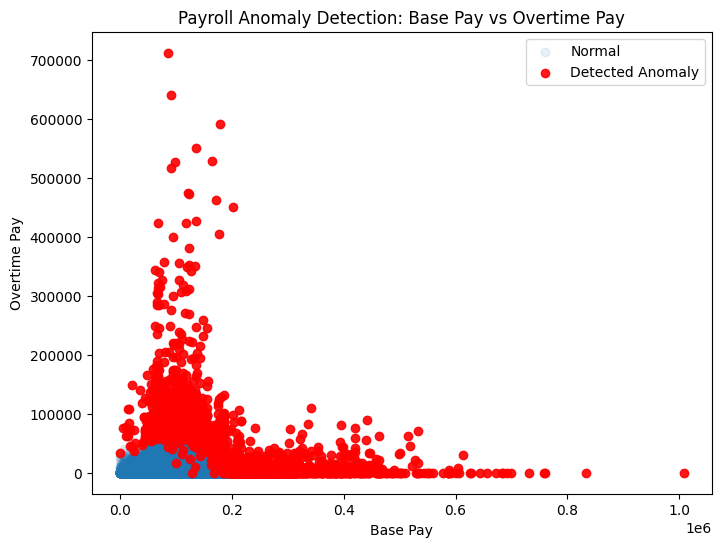

anomaly_label
 1    97.999932
-1     2.000068
Name: proportion, dtype: float64

In [8]:
import matplotlib.pyplot as plt

anomaly_idx = np.where(prediction < 0)[0]
X_np = X.values

plt.figure(figsize=(8, 6))

#Plot all points in blue (normal background)
plt.scatter(
    X_np[:, 0],
    X_np[:, 1],
    alpha=0.1,
    label="Normal",
)

# Plot only anomaly points in red using indexes
plt.scatter(
    X_np[anomaly_idx, 0],
    X_np[anomaly_idx, 1],
    color="red",
    alpha=0.9,
    label="Detected Anomaly"
)

plt.xlabel("Base Pay")
plt.ylabel("Overtime Pay")
plt.title("Payroll Anomaly Detection: Base Pay vs Overtime Pay")
plt.legend()
plt.show()
df["anomaly_label"].value_counts(normalize=True) * 100


## 9. Real-Time and Batch Pipeline Design

A production-ready payroll anomaly detection system must support both historical analysis 
(batch processing) and live monitoring (real-time processing). This project proposes a 
hybrid pipeline architecture to handle both scenarios efficiently.

---

### Batch Processing Pipeline

The batch pipeline is responsible for analyzing historical payroll data and periodically 
retraining the anomaly detection model.

**Workflow:**
1. Payroll data is stored in a data source (e.g., CSV files, data warehouse, or database)
2. Batch jobs load historical payroll records at scheduled intervals
3. Data preprocessing and feature scaling are applied
4. Isolation Forest is trained or retrained on recent data
5. The trained model is versioned and stored for deployment

**Use cases:**
- Monthly or quarterly payroll audits
- Model retraining using recent payroll trends
- Offline anomaly analysis and reporting

---

### Real-Time Processing Pipeline

The real-time pipeline detects anomalies as payroll events occur.

**Workflow:**
1. Payroll events are received via an API (e.g., salary update, overtime submission)
2. Incoming data is validated and preprocessed in real time
3. The deployed Isolation Forest model generates an anomaly score
4. High-risk payroll records are flagged instantly
5. Alerts or logs are generated for further investigation

**Use cases:**
- Real-time detection of fake overtime claims
- Immediate flagging of abnormal salary changes
- Continuous monitoring of payroll activity

---

### Architecture Summary

- Batch pipeline focuses on **model learning and historical insights**
- Real-time pipeline focuses on **low-latency anomaly detection**
- Both pipelines share the same preprocessing logic to ensure consistency


## 10. Concept Drift Detection & Handling

Concept drift refers to changes in payroll data patterns over time that can reduce the accuracy of an anomaly detection system. In payroll environments, drift is common due to salary revisions, policy updates, promotions, inflation, and evolving overtime practices.

----

### Drift Detection Approach

Since Isolation Forest is an unsupervised model, drift is monitored by tracking model behavior, not labels.
The system continuously evaluates the anomaly rate produced by the model and compares it against the expected baseline defined during training.

- `1` → Normal record

- `-1` → Anomalous record

A significant deviation in the observed anomaly rate indicates potential drift.
    drift_status = detect_concept_drift(df["anomaly_label"])

If the current anomaly rate exceeds the expected rate (e.g., 2%) by a defined threshold, drift is flagged.

----

### Drift Mitigation Strategy

When drift is detected, the following actions are recommended:

- Model retraining using recent payroll data

- Sliding window training to adapt to current salary distributions

- Threshold recalibration to reflect new payroll norms

- Human validation for high-risk payroll anomalies

----

### Why Isolation Forest Is Suitable

Isolation Forest does not rely on labeled data or fixed decision boundaries. Monitoring its anomaly rate provides a lightweight and effective mechanism for detecting distributional changes, making it well-suited for dynamic payroll systems.


In [9]:
def detect_concept_drift(
    anomaly_predictions,
    expected_anomaly_rate=0.02,
    drift_threshold=0.05
):

    predictions = np.array(anomaly_predictions)

    total_records = len(predictions)
    anomaly_count = np.sum(predictions == -1)

    current_anomaly_rate = anomaly_count / total_records

    drift_detected = current_anomaly_rate > (
        expected_anomaly_rate + drift_threshold
    )

    return {
        "total_records_checked": total_records,
        "anomalies_detected": int(anomaly_count),
        "current_anomaly_rate": round(float(current_anomaly_rate), 4),
        "expected_anomaly_rate": expected_anomaly_rate,
        "drift_detected": bool(drift_detected)
    }

drift_status = detect_concept_drift(df["anomaly_label"])
drift_status


{'total_records_checked': 148045,
 'anomalies_detected': 2961,
 'current_anomaly_rate': 0.02,
 'expected_anomaly_rate': 0.02,
 'drift_detected': False}

## 11. Deployment and Monitoring Plan

This section outlines how the payroll anomaly detection system can be deployed and maintained 
in a production environment, ensuring scalability, reliability, and continuous monitoring.

---

### Model Deployment

- The trained Isolation Forest model is serialized using tools such as `joblib` or `pickle`
- The model is deployed as a RESTful API using frameworks like FastAPI or Flask
- The API exposes an endpoint to receive payroll data and return anomaly scores and flags
- Preprocessing steps (scaling, feature selection) are applied consistently before inference

---

### Real-Time Inference Workflow

1. Payroll event data is sent to the anomaly detection API
2. Input data is validated and transformed
3. The model generates an anomaly score and prediction
4. High-risk payroll records are flagged in real time
5. Alerts or logs are generated for audit and review

---

### Monitoring and Maintenance

To ensure long-term reliability, the following metrics are monitored:

- Anomaly detection rate over time
- Distribution of payroll features
- Model inference latency
- System errors and failures

Significant deviations in these metrics may indicate concept drift or system issues.

---

### Retraining and Model Updates

- Scheduled retraining using recent payroll data
- Versioning of models for rollback and comparison
- Controlled deployment of updated models to production
- Continuous evaluation using historical trends and analyst feedback

---

### Security and Compliance Considerations

- Secure API access with authentication and authorization
- Encryption of sensitive payroll data
- Logging and auditing for compliance and traceability


## 12️. Real-Time Payroll Anomaly Detection API (Simulation)

### Overview:
This project includes a real-time payroll anomaly detection API built using FastAPI, complementing the batch anomaly detection pipeline.
The API simulates how payroll transactions are evaluated instantly in real-world payroll systems.

----

### What is Simulation?

The real-time component is a simulation, meaning payroll records are manually sent to the API instead of coming from live enterprise systems.
However, the architecture and inference logic closely mirror real production deployments.

----

### Model Persistence with Joblib

- To enable real-time inference, trained artifacts are serialized using joblib (.pkl files, where pkl = pickle).

- `isolation_forest_model.pkl`
    Stores the trained Isolation Forest model used for anomaly prediction.

- `scaler.pkl`
    Stores the fitted feature scaler to ensure real-time inputs are preprocessed identically to training data.

----

### API Design

***Health Check Endpoint***
        `GET /`

***POST /predict***
       ` POST /predict`

**Inputs:**
- `BasePay`

- `OvertimePay`

- `TotalPay`

Processing Flow:

- Input conversion to DataFrame

- Feature scaling using scaler.pkl

- Anomaly prediction using      isolation_forest_model.pkl

- Risk classification (NORMAL / HIGH RISK)

**Outputs:**
- `anomaly_flag`

- `anomaly_score`

- `risk_level`

----

### Swagger UI for Testing

FastAPI provides an interactive Swagger UI for testing the API:

        http://127.0.0.1:8000/docs

Two execution scenarios were tested:

- Normal payroll record

- Suspicious payroll record

Swagger UI outputs were saved as PDF files and included as execution proof.

----

### Business Value

Real-time detection enables immediate flagging of suspicious payroll entries, reducing financial risk and improving audit readiness.
Combined with batch analysis, this forms a complete Payroll Anomaly Detection Engine.
               

### Real-Time API Implementation

The real-time anomaly detection API is implemented in a separate file (`api.py`)
using FastAPI. The API loads the trained Isolation Forest model and scaler
(serialized using joblib) and exposes a `/predict` endpoint for real-time inference.

The notebook focuses on batch model development, while `api.py` represents
the production-style deployment layer.


In [10]:
import joblib

joblib.dump(iso_forest, "isolation_forest_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

## Conclusion

This project demonstrates an end-to-end Payroll Anomaly Detection Engine using an unsupervised learning approach with Isolation Forest. The solution effectively identifies irregular salary and overtime patterns without relying on labeled data, making it suitable for real-world payroll environments.

The system supports both batch analysis and real-time anomaly detection through a FastAPI-based deployment, with model persistence handled via serialized artifacts. Additionally, a lightweight concept drift monitoring strategy ensures long-term reliability by detecting changes in payroll behavior and enabling timely retraining.

Overall, this project showcases a scalable, production-ready anomaly detection framework that balances analytical robustness with practical deployment considerations.